In [1]:
"""
Created on Tue Jun 29 11:01:00 2021

@author: J. Barrett Carter

This is a function that will be used to automatically generate synthetic topo-
graphy from a specified elevation profile.

The 'site_file_name' variable must be a csv file containing a column for distance
labeled 'Distance' and a column for elevation labeled 'Elevation'. The distance
should be measured from a point on land to a point at sea, and the 'Distance' values
should be orded from smallest to largest.

The options for the shape parameter are either 'straight', 'curved', or 'points'. The options
for the bay parameter are True or False. The options for the plot parameter are
0, 1, 2, or 3; 0 meaning no plot, 1 meaning just profile plots, 2 meaning just
heatmaps, 3 meaning both.

return_z is either True or False and determines if the z-arrays are returned.

dim is the dimension of the coarse z-array in km.

"""
def generate_topo(site_file_name,directory,shape,bay = False,plot = 3,
                  return_z = True, dim = 5000):

    import numpy as np
    from scipy.interpolate import CubicSpline
    from scipy.interpolate import interp1d
    from matplotlib import pyplot as plt
    import seaborn as sns; sns.set_theme()
    
    #%%
    import pandas as pd
    import os
    from skimage.measure import block_reduce
    
    datadir = os.path.join(directory) # directory for elevation profile data files
    filename = site_file_name
    file2 = "OceanDepth.csv"
    filepath2 = os.path.join(datadir, file2)
    filepath = os.path.join(datadir, filename)
    df = pd.read_csv(filepath)
    df2 = pd.read_csv(filepath2)
    df2 = df2.loc[0:16,:]
    
    #%%
    ### Generate fine topography
    elev = df.loc[:,'Elevation']
    dist = df.loc[:,'Distance']
    elev = elev[0:10001]
    dist = dist[0:10001]
    elev = elev.to_numpy()
    elev = np.flip(elev)
    dist = dist.to_numpy()
    #%%
    #Create spline model
    
    cs = CubicSpline(dist,elev)
    
    syn_elev = cs(dist)
    
    #%%
    
    #Generating Plots
    
    if (plot == 1) or (plot == 3):
    
        plt.figure()
        plt.plot(dist, elev, linewidth=2, label='Elevation Profile')
        plt.plot(dist, syn_elev, linewidth=1, label='Spline Model')
        plt.xlabel('Distance (degrees)')
        plt.ylabel('Elevation (m)')
        plt.title(site_file_name)
        plt.legend(loc='best')
    
    #%%
    # Making it 3D
    
    y = dist
    x = y
    z = np.zeros((len(y),len(x)))
    
    #%%
    # Defining the shorline shoreline (z=0 contour)
    above_sl = elev>-5
    # above_sl = above_sl.to_numpy()
    base_shore = int(min(np.argwhere(above_sl)))
    y_bs = y[base_shore]
    x_max = max(x)
    y_max = max(y)
    
    # give shoreline shape
    if shape == 'straight':
        s = np.ones(len(y))*y_bs # flat shoreline
    if shape == 'curved':
        s = y_bs+2000*abs(np.sin((x)*np.pi/x_max)) # one big curve
    if shape == 'points':
        s = y_bs+2000*abs(np.sin((x+x_max/4)*2*np.pi/x_max)) #curved with points
    
    # add in triangular bay centered at x = x_bay
    if bay == True:
        sb = np.empty((len(y)))
        sb[:]=np.NaN
        x_bay = x_max/2
        bay_width = 4000
        bay_height = 8000
        out_bay = np.logical_or(x<(x_bay-bay_width/2),x>(x_bay+bay_width/2))
        in_bay = out_bay==False
        sb[out_bay]= np.NaN
        sb[in_bay] = s[int(len(s)/2+bay_width/2/3)]+bay_height-abs(x[in_bay]-x_bay)*\
            bay_height/(bay_width/2)
        
        # add in transition
        
        trans = np.empty((len(y)))
        trans[:]=np.NaN
        trans_width = 1000
        out_trans = np.logical_or(x<(x_bay-bay_width/2-trans_width),x>(x_bay+bay_width/2+trans_width))
        in_trans = out_trans==False
        trans[out_trans]= np.NaN
        trans[in_trans] = s[int(len(s)/2+(bay_width/2+trans_width)/3)]+bay_height-\
            abs(x[in_trans]-x_bay)*bay_height/(bay_width/2)+trans_width*bay_height*2/bay_width
        
        # add in river
        
        river_width = bay_width/10
        x_riv = np.logical_and(x > x_bay-river_width/2, x < x_bay+river_width/2)
    #%%

    # to make 2d grid of z values
    for col in range(z.shape[1]):

        ynew = y-s[col]+y_bs
        ynew[ynew<0]=0
        ynew[ynew>y_max]=y_max
        z[:,col]=cs(ynew)
        if (bay == True) and (in_bay[col]==True):
            y_bay = np.logical_and(y>s[col],y<sb[col])
            z[y_bay,col]=-5
            if x_riv[col]==True:
                y_riv = y>sb[col]
                z[y_riv,col]=-5
    
    #%%
    
#Add in transition
    if bay == True:
        for yind in range(z.shape[0]):
            if y[yind]>=min(trans[np.isnan(trans)==False]):
                if y[yind]<max(sb[np.isnan(sb)==False]):
                    
                    zcross = z[yind,:]
                    
                    left_trans = np.logical_and(x<x_bay,trans>=y[yind])
                    right_trans = np.logical_and(x>x_bay,trans>=y[yind])
                    
                    zcross[left_trans]=np.nan
                    zcross[right_trans]=np.nan
                    
                    xsub = x[np.isnan(zcross)==False]
                    zcross = zcross[np.isnan(zcross)==False]

                    cs2 = interp1d(xsub,zcross)
                    
                    zcross_syn = cs2(x)
                    
                    z[yind,:]=zcross_syn
                    
                if y[yind]>=max(sb[np.isnan(sb)==False]):
                    zcross = z[yind,:]
                    
                    left_trans = np.logical_and(x<x_bay,x>x_bay-river_width/2-trans_width)
                    right_trans = np.logical_and(x>x_bay,x<x_bay+river_width/2+trans_width)
                    
                    zcross[left_trans]=np.nan
                    zcross[right_trans]=np.nan
                    
                    xsub = x[np.isnan(zcross)==False]
                    zcross = zcross[np.isnan(zcross)==False]
                    
                    cs2 = interp1d(xsub,zcross)
                    
                    zcross_syn = cs2(x)
                    
                    z[yind,:]=zcross_syn
    
    #%%
    
    #heatmap
    if (plot == 2) or (plot == 3):
        xis = np.linspace(0,len(x),num = 1000,endpoint=False).astype(int)
        yis = np.linspace(0,len(y),num = 1000,endpoint=False).astype(int)
        zis = np.meshgrid(yis,xis,indexing = 'ij')
        zsub = z[zis]
        zsub = np.flip(zsub)
        plt.figure()
        ax = sns.heatmap(zsub,cmap='seismic',center=0)
    
    #%%
    ## Generate coarse topography
    
    elev = df.loc[:,'Elevation']
    dist = df.loc[:,'Distance']
    elev = elev[0:10001]
    dist = dist[0:10001]
    elev2 = df2.loc[:,'dpeth']
    dist2 = df2.loc[:,'X-axis']
#%%

    elev = elev.to_numpy() 
    elev2 = elev2.to_numpy()
    dist = dist.to_numpy()/1000 #changed to kilometers
    dist2=dist2.to_numpy()/1000


#%%

#making the two match up


    elev = np.flip(elev)
    elev2 = elev2+elev[0]-elev2[0]
    dist=dist+max(dist2)+1

    dist2 = np.flip(dist2)
    elev2 = np.flip(elev2)
    dist2 = (dist2-max(dist2))*(-1)
    
    elev = np.concatenate([elev2,elev])
    dist = np.concatenate([dist2,dist])

    if (plot == 1) or (plot == 3):
        plt.figure()
        plt.plot(dist[15:10037],elev[15:10037])
        plt.figure()
        plt.plot(dist,elev)

#%%
    
    dist = dist + dim- max(dist)
    dist =np.append(0,dist)
    elev = np.append(min(elev),elev)
    if (plot == 1) or (plot == 3):
        plt.figure()
        plt.plot(dist,elev)
#%%
#Create mathematical model

    interp = interp1d(dist, elev)
    
    y = np.linspace(1,dim,num=dim)
    syn_elev = interp(y)


#%%

#Generating Plots

    if (plot == 1) or (plot == 3):
    
        plt.figure(figsize=(10,10))
        plt.subplot(3, 1, 1)
        plt.plot(dist, elev, 'bo-', linewidth=2, label='Elev Prof Site 1')
        plt.plot(y, syn_elev,color = 'orange', linewidth=1, label='Syn topo smooth')
        plt.xlabel('Distance (km)')
        plt.ylabel('Elevation (m)')
        plt.legend(loc='best')
        
        plt.subplot(3, 1, 2)
        plt.plot(dist[dist>dim-1000], elev[dist>dim-1000],'bo-', linewidth=2, label='Elev Prof Site 1')
        plt.plot(y[y>dim-1000], syn_elev[y>dim-1000], color = 'orange',linewidth=1, label='Syn topo rough')
        plt.xlabel('Distance (km)')
        plt.ylabel('Elevation (m)')
        plt.legend(loc='best')
        
        plt.subplot(3, 1, 3)
        plt.plot(dist[dist>dim-30], elev[dist>dim-30], 'bo-',linewidth=2, label='Elev Prof Site 1')
        plt.plot(y[y>dim-30], syn_elev[y>dim-30], color = 'orange',linewidth=1, label='Syn topo rough')
        plt.xlabel('Distance (km)')
        plt.ylabel('Elevation (m)')
        plt.legend(loc='best')

#%%
# Making it 3D

    x = y
    z_coarse = np.zeros((len(y),len(x)))

#%%
    # Defining the shorline shoreline (z=0 contour)
    below_sl = syn_elev<-5
    base_shore = int(max(np.argwhere(below_sl)))
    y_bs = y[base_shore]
    x_max = max(x)
    y_max = max(y)
    x_max_fine = max(df['X_axis'])*3/1000
    
    if shape == 'straight':
        s = np.ones(len(y))*y_bs # flat shore
    if shape == 'curved':
        s = y_bs+2*abs(np.sin((x-x_max/2+x_max_fine/2)*np.pi/x_max_fine)) # one big curve
    if shape == 'points':
        s = y_bs+2*abs(np.sin((x-x_max/2+x_max_fine/4)*2*np.pi/x_max_fine)) #curved with points
    
    
    # add in triangular bay centered at x = x_bay
    if bay == True:
        sb = np.empty((len(y)))
        sb[:]=np.NaN
        x_bay = x_max/2
        bay_width = 4
        bay_height = 8
        out_bay = np.logical_or(x<(x_bay-bay_width/2),x>(x_bay+bay_width/2))
        in_bay = out_bay==False
        sb[out_bay]= np.NaN
        sb[in_bay] = s[int(len(s)/2+bay_width/2)]+bay_height-abs(x[in_bay]-x_bay)*\
            bay_height/(bay_width/2)
        
        # add in transition
        
        trans = np.empty((len(y)))
        trans[:]=np.NaN
        trans_width = 1
        out_trans = np.logical_or(x<(x_bay-bay_width/2-trans_width),x>(x_bay+bay_width/2+trans_width))
        in_trans = out_trans==False
        trans[out_trans]= np.NaN
        trans[in_trans] = s[int(len(s)/2+(bay_width/2+trans_width))]+bay_height-\
            abs(x[in_trans]-x_bay)*bay_height/(bay_width/2)+trans_width*bay_height*2/bay_width
        
        # add in river
        
        river_width = bay_width/10
        x_riv = np.logical_and(x > x_bay-river_width/2, x < x_bay+river_width/2)
        
    
#%%


    # to make 2d grid of z values
    for col in range(z_coarse.shape[1]):

        ynew = y-s[col]+y_bs
        ynew[ynew<0]=0
        ynew[ynew>y_max]=y_max
        z_coarse[:,col]=interp(ynew)
        if (bay==True) and (in_bay[col]==True):
            y_bay = np.logical_and(y>s[col],y<sb[col])
            z_coarse[y_bay,col]=-5
            if x_riv[col]==True:
                y_riv = y>sb[col]
                z_coarse[y_riv,col]=-5

#%%
    if (plot == 2) or (plot == 3): 
        #heatmap
        xis = np.linspace(0,len(x),num = 1000,endpoint=False).astype(int)
        yis = np.linspace(0,len(y),num = 1000,endpoint=False).astype(int)
        zis = np.meshgrid(yis,xis,indexing = 'ij')
        zsub = z_coarse[zis]
        zsub = np.flip(zsub)
        plt.figure()
        ax = sns.heatmap(zsub,cmap='seismic',center=0)
    
    #%%
    
  
    # Block reduction to coarsen the fine topography to 27 m from 3 m file
    # block_size = (m,n) Array containing downsampling integer factor along each axis 
    z_27 = block_reduce(z, block_size=(9, 9), func=np.mean) 
    
    if return_z == True:
        return(z,z_27,z_coarse)
    
    #%%



<ipython-input-1-0b2cf628a7f8>:195: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  zsub = z[zis]
<ipython-input-1-0b2cf628a7f8>:360: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  zsub = z_coarse[zis]


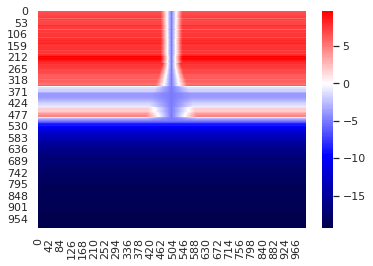

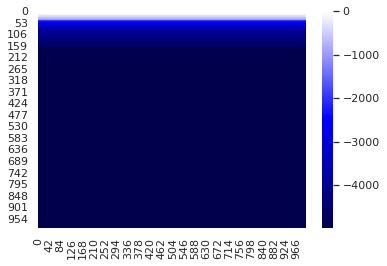

In [2]:
# Using the code to generate synthetic topo files.

my_dir = '/home/jovyan/data/hydroinformatics/syn_topo/data/Elevation_profile_30km/'
profiles = ['Barnegat_bay_NJ.csv','Marley_beach_SC.csv','Melbourne_FL.csv',
            'Savannah_GA.csv','Shallotte_NC.csv']

zs = generate_topo(site_file_name='Melbourne_FL.csv', directory = my_dir,shape = 'straight', bay = True, plot = 2)
# generate_topo(site_file_name='Shallotte_profile.csv',shape = 'curved', bay = True, plot = 3)
#for profile in profiles:
#    generate_topo(site_file_name=profile, directory = my_dir,shape = 'straight', 
#                  bay = True, plot = 3)

topo_fine = zs[0]
topo_fine_27 = zs[1]
topo_coarse = zs[2]

In [3]:
print(topo_fine.shape) #units in m
print(topo_fine_27.shape) #units in m
print(topo_coarse.shape) #units in km

(10001, 10001)
(1112, 1112)
(5000, 5000)


In [4]:
# Using topotools to create synthetic topography (in m)
from __future__ import print_function
from clawpack.geoclaw import topotools
import os
CLAW = os.environ['CLAW']
import netCDF4
import numpy
import numpy as np

syn_file_dir = '/home/jovyan/data/topo_files_output/'

# place fine topography in upper-center region
topo_file_fine = topotools.Topography()
topo_file_fine.x = numpy.linspace((2500-15)*1000,(2500+15)*1000,topo_fine.shape[1],endpoint=False) 
topo_file_fine.y = numpy.linspace((5000-30)*1000,5000*1000,topo_fine.shape[0],endpoint=False) 
topo_file_fine.Z = topo_fine

# topo_file_fine.write(os.path.join(syn_file_dir, 'Melbourne_FL_m.nc' ), topo_type=4)
topo_file_fine.write(os.path.join(syn_file_dir, 'Mel_s_b_3_m.txt' ), topo_type=3)

# place fine_27 topography in upper-center region
topo_file_fine_27 = topotools.Topography()
topo_file_fine_27.x = numpy.linspace((2500-15)*1000,(2500+15)*1000,topo_fine_27.shape[1],endpoint=False) 
topo_file_fine_27.y = numpy.linspace((5000-30)*1000,5000*1000,topo_fine_27.shape[0],endpoint=False) 
topo_file_fine_27.Z = topo_fine_27

# topo_file_fine.write(os.path.join(syn_file_dir, 'Mel_s_nb_27_m.nc' ), topo_type=4)
topo_file_fine_27.write(os.path.join(syn_file_dir, 'Mel_s_b_27_m.txt' ), topo_type=3)

topo_file_coarse = topotools.Topography()
topo_file_coarse.x = np.linspace(0,topo_coarse.shape[1]*1000,topo_coarse.shape[1]) # changing it to m
topo_file_coarse.y = np.linspace(1,topo_coarse.shape[0]*1000,topo_coarse.shape[0]) # changing it to m
topo_file_coarse.Z = topo_coarse

# topo_file_coarse.write(os.path.join(syn_file_dir, 'Mel_s_nb_coarse_m.nc'), topo_type = 4)
topo_file_coarse.write(os.path.join(syn_file_dir, 'Mel_s_b_coarse_m.txt'), topo_type = 3)


In [ ]:
# Plotting the fine resolution
import numpy
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from clawpack.visclaw import plottools
import clawpack.visclaw.colormaps as colormaps
import clawpack.geoclaw.topotools as tt

syn_file_dir = '/home/jovyan/data/topo_files_output/'
# path = os.path.join(syn_file_dir, 'Melbourne_FL_m.txt' )
# # Load topography
# topo = tt.Topography(path, topo_type=3)

path = os.path.join(syn_file_dir, 'Melbourne_FL_m.nc' )
# Load topography
topo = tt.Topography(path, topo_type=4)

# Plot settings
data_break = 0.0
topo_extent = (numpy.min(topo.Z), numpy.max(topo.Z))
region_extent = topo.extent

# Make colormap
land_cmap = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                                 0.25:[0.0,1.0,0.0],
                                                  0.5:[0.8,1.0,0.5],
                                                  1.0:[0.8,0.5,0.2]})
sea_cmap = plt.get_cmap('Blues_r')
cmap, norm = colormaps.add_colormaps((land_cmap, sea_cmap), 
                                     data_limits=topo_extent,
                                     data_break=data_break)

# Plot topo
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
plot = plottools.pcolorcells(topo.X, topo.Y, topo.Z, axes=axes, norm=norm, cmap=cmap)
cbar = plt.colorbar(plot, ax=axes)

# expand extent to include full cells, which are centered at X,Y:
x1 = topo.x.min() - topo.delta[0]/2.
x2 = topo.x.max() + topo.delta[0]/2.
y1 = topo.y.min() - topo.delta[1]/2.
y2 = topo.y.max() + topo.delta[1]/2.

axes.set_xlim(x1,x2)
axes.set_ylim(y1,y2)

# Set aspect
mean_coord = 0.5 * (region_extent[3] + region_extent[2])
# axes.set_aspect(1.0 / numpy.cos(numpy.pi / 180.0 * mean_lat))
axes.set_aspect('equal')

plt.show()
#plt.savefig(os.path.join(syn_file_dir, 'Melbourne_FL_m.png')) 

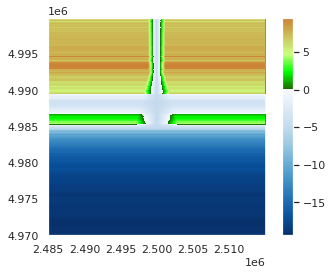

In [5]:
# Plotting the fine 27m resolution
import numpy
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from clawpack.visclaw import plottools
import clawpack.visclaw.colormaps as colormaps
import clawpack.geoclaw.topotools as tt

syn_file_dir = '/home/jovyan/data/topo_files_output/'
# path = os.path.join(syn_file_dir, 'Melbourne_FL_27_m.txt' )
# # Load topography
# topo = tt.Topography(path, topo_type=3)

path = os.path.join(syn_file_dir, 'Mel_s_b_27_m.txt' )
# Load topography
topo = tt.Topography(path, topo_type=3)

# Plot settings
data_break = 0.0
topo_extent = (numpy.min(topo.Z), numpy.max(topo.Z))
region_extent = topo.extent

# Make colormap
land_cmap = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                                 0.25:[0.0,1.0,0.0],
                                                  0.5:[0.8,1.0,0.5],
                                                  1.0:[0.8,0.5,0.2]})
sea_cmap = plt.get_cmap('Blues_r')
cmap, norm = colormaps.add_colormaps((land_cmap, sea_cmap), 
                                     data_limits=topo_extent,
                                     data_break=data_break)

# Plot topo
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
plot = plottools.pcolorcells(topo.X, topo.Y, topo.Z, axes=axes, norm=norm, cmap=cmap)
cbar = plt.colorbar(plot, ax=axes)

# expand extent to include full cells, which are centered at X,Y:
x1 = topo.x.min() - topo.delta[0]/2.
x2 = topo.x.max() + topo.delta[0]/2.
y1 = topo.y.min() - topo.delta[1]/2.
y2 = topo.y.max() + topo.delta[1]/2.

axes.set_xlim(x1,x2)
axes.set_ylim(y1,y2)

# Set aspect
mean_coord = 0.5 * (region_extent[3] + region_extent[2])
# axes.set_aspect(1.0 / numpy.cos(numpy.pi / 180.0 * mean_lat))
axes.set_aspect('equal')

plt.show()
#plt.savefig(os.path.join(syn_file_dir, 'Melbourne_FL_m.png')) 


In [ ]:
# Plotting the coarse resolution 
import numpy
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from clawpack.visclaw import plottools
import clawpack.visclaw.colormaps as colormaps
import clawpack.geoclaw.topotools as tt

syn_file_dir = '/home/jovyan/data/topo_files_output/'
# path = os.path.join(syn_file_dir, 'Melbourne_FL_coarse_m.txt' )
# # Load topography
# topo = tt.Topography(path, topo_type=3)

path = os.path.join(syn_file_dir, 'Melbourne_FL_coarse_m.nc' )
# Load topography
topo = tt.Topography(path, topo_type=4)

# Plot settings
data_break = 0.0
topo_extent = (numpy.min(topo.Z), numpy.max(topo.Z))
region_extent = topo.extent

# Make colormap
land_cmap = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                                 0.25:[0.0,1.0,0.0],
                                                  0.5:[0.8,1.0,0.5],
                                                  1.0:[0.8,0.5,0.2]})
sea_cmap = plt.get_cmap('Blues_r')
cmap, norm = colormaps.add_colormaps((land_cmap, sea_cmap), 
                                     data_limits=topo_extent,
                                     data_break=data_break)

# Plot topo
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
plot = plottools.pcolorcells(topo.X, topo.Y, topo.Z, axes=axes, norm=norm, cmap=cmap)
cbar = plt.colorbar(plot, ax=axes)

# expand extent to include full cells, which are centered at X,Y:
x1 = topo.x.min() - topo.delta[0]/2.
x2 = topo.x.max() + topo.delta[0]/2.
y1 = topo.y.min() - topo.delta[1]/2.
y2 = topo.y.max() + topo.delta[1]/2.

axes.set_xlim(x1,x2)
axes.set_ylim(y1,y2)

# Set aspect
mean_coord = 0.5 * (region_extent[3] + region_extent[2])
# axes.set_aspect(1.0 / numpy.cos(numpy.pi / 180.0 * mean_lat))
axes.set_aspect('equal')

plt.show()